In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing

In [2]:
TRAIN_DIR = '/kaggle/input/stock-reversal-patterns/images/'

In [3]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  validation_split=0.2)

In [4]:
train_images = train_generator.flow_from_directory(directory=TRAIN_DIR, 
                                                   target_size=(480, 480), 
                                                   class_mode='categorical', 
                                                   batch_size=50, 
                                                   subset='training')

val_images = train_generator.flow_from_directory(directory=TRAIN_DIR, 
                                                 target_size=(480, 480), 
                                                 class_mode='categorical', 
                                                 batch_size=50, 
                                                 subset='validation')

Found 24000 images belonging to 6 classes.
Found 6000 images belonging to 6 classes.


In [5]:
labels = os.listdir(TRAIN_DIR)
labels.sort()

In [6]:
batch = next(train_images)

(50, 480, 480, 3)
double_bottom


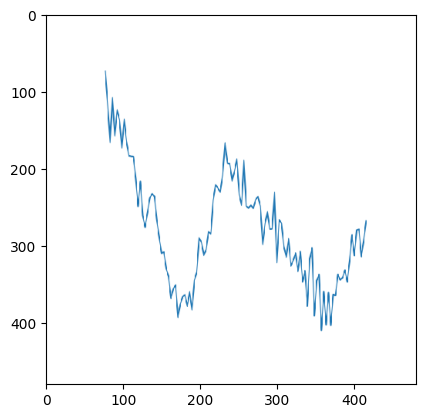

In [7]:
batch = next(train_images)
print(batch[0].shape)
print(labels[np.argmax(batch[1][0])])
plt.imshow(batch[0][0])

## Model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(10, 10), strides=4, activation='relu', input_shape=(480, 480, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=2, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), strides=2, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=6, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      9632      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 96)          55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 96)          0

In [10]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics = ['accuracy'])

In [11]:
history = model.fit(train_images, 
                    epochs=3, 
                    validation_data=val_images)

Epoch 1/3
480/480 [==============================] - 463s 956ms/step - loss: 0.1875 - accuracy: 0.9303 - val_loss: 0.0189 - val_accuracy: 0.9942
Epoch 2/3
480/480 [==============================] - 401s 835ms/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.0094 - val_accuracy: 0.9968
Epoch 3/3
480/480 [==============================] - 404s 841ms/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0131 - val_accuracy: 0.9957


In [12]:
model.save('stock-pattern-classification')
!zip -r ./stock-pattern-classification-model.zip ./stock-pattern-classification

  adding: stock-pattern-classification/ (stored 0%)
  adding: stock-pattern-classification/variables/ (stored 0%)
  adding: stock-pattern-classification/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: stock-pattern-classification/variables/variables.index (deflated 63%)
  adding: stock-pattern-classification/saved_model.pb (deflated 87%)
  adding: stock-pattern-classification/keras_metadata.pb (deflated 91%)
  adding: stock-pattern-classification/fingerprint.pb (stored 0%)
  adding: stock-pattern-classification/assets/ (stored 0%)


## Incorrect Classifications

True: triple_bottom
Predicted: inverse_head_and_shoulders



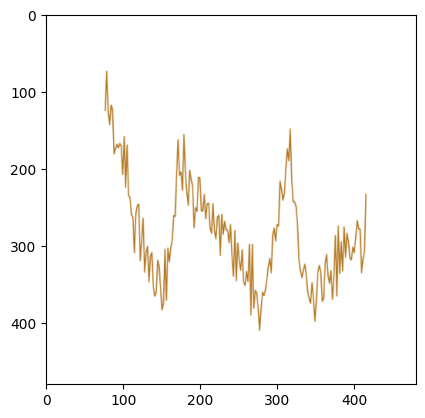

In [13]:
true_category, pred_category = None, None
while true_category == pred_category:
    true_category = np.random.choice(labels)
    img = cv2.imread(TRAIN_DIR + true_category + '/' + str(np.random.randint(0, 1000)) + '.png')
    img = cv2.resize(img, (480, 480))
    pred_category = labels[np.argmax(model.predict(img.reshape(1, 480, 480, 3), verbose=0))]
print(f'True: {true_category}\nPredicted: {pred_category}\n')
plt.imshow(img)